# Lecture-10 Build a neural network from sractch

## Target: using python and numpy implement a neural network framework.

---

- forward: Function, how to calculate the inputs
- backwards: Function, how to get the gradients when backpropogation
- gradients: Mapper, the gradient map the this node of its inputs node
- inputs: List, the input nodes of this node
- outputs: List, the output node of this node

---

## 面向对象的方式来组织

### 构建基类

In [1]:
import numpy as np
from sklearn.utils import resample
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Node:
    # 相当于构造器，对于每个节点有多个输入（List）和多个输出（List）
    def __init__(self, inputs=[], name=''):
        self.inputs = inputs  # 输入节点 list
        self.outputs = []     # 输出节点 list
        self.name = name      # 可以为每个节点起一个名字
        self.gradients = {}   # 节点的梯度
        self.value = None     # 节点的值，通过前向计算出来的
        
        for node in inputs:
            node.outputs.append(self)

    def forward(self):
        raise NotImplemented # NotImplemented 表示该函数是一个抽象函数，子类继承该类需要重写该函数
        
    def backward(self):
        raise NotImplemented
    
    # 该函数是为了打印类名和节点的名称
    def __repr__(self):
        return f'< {self.__class__.__name__}:{self.name} >'

In [3]:
# Input(Node) 表示 Input 继承 Node
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[], name=name)
        self.name = name
    
    def forward(self, value=None):
        if value is not None: self.value = value
        
    def backward(self):
        self.gradients = {}
        for output in self.outputs:
            upstream_gradient = output.gradients[self]
            self.gradients[self] = upstream_gradient ####

In [4]:
class Linear(Node):
    def __init__(self, nodes, weights, bias, name=''):
        self.node_x = nodes
        self.node_w = weights
        self.node_b = bias
        Node.__init__(self, inputs=[nodes, weights, bias], name=name)
        
    def forward(self):
        self.value = np.dot(self.node_x.value, self.node_w.value) + self.node_b.value
        
    def backward(self):
        for output in self.outputs:
            grad_cost = output.gradients[self]
            self.gradients[self.node_w] = np.dot(self.node_x.value.T, grad_cost)
            self.gradients[self.node_b] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.node_x] = np.dot(grad_cost, self.node_w.value.T)

In [5]:
class Sigmoid(Node):
    def __init__(self, node, name=''):
        Node.__init__(self, [node], name=name)
        self.node_x = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-x))
    
    def forward(self):
        self.value = self._sigmoid(self.node_x.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y) # 求偏导
        
        for output in self.outputs:
            upstream_gradient = output.gradients[self]
            self.gradients[self.node_x] = upstream_gradient * self.partial

In [6]:
class MSE(Node):
    def __init__(self, y_true, y_hat, name=''):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat], name=name)
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [7]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [8]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [9]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [10]:
data = load_boston()
_X = data['data']
_y = data['target']

features = _X.shape[1]
_X = (_X - _X.mean(axis=0)) / _X.std(axis=0)

hidden_layer_1_nodes = 32
hidden_layer_2_nodes = 32

_W1, _b1 = np.random.randn(features, hidden_layer_1_nodes), np.zeros(hidden_layer_2_nodes)
_W2, _b2 = np.random.randn(hidden_layer_2_nodes, 1), np.zeros(1)

### Build Graph

In [11]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

In [12]:
linear_output = Linear(X, W1, b1, name='L1')
sigmoid_output = Sigmoid(linear_output, name='sigmoid')
yhat = Linear(sigmoid_output, W2, b2, name='L2')
loss = MSE(y, yhat, name='MSE')

In [13]:
input_node_with_value = {  # -> feed_dict 
    X: _X, 
    y: _y, 
    W1: _W1, 
    W2: _W2, 
    b1: _b1, 
    b2: _b2
}

In [14]:
graph = topological_sort(input_node_with_value)

In [15]:
graph

[< Input:b2 >,
 < Input:b1 >,
 < Input:W1 >,
 < Input:W2 >,
 < Input:X >,
 < Input:y >,
 < Linear:L1 >,
 < Sigmoid:sigmoid >,
 < Linear:L2 >,
 < MSE:MSE >]

In [16]:
losses = []
epochs = 8000
batch_size = 64
n_samples = _X.shape[0]
n_batches = (n_samples-1) // batch_size+1
lr = 1e-2

for i in range(epochs):
    loss = .0
    
    for batch in range(n_batches):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
#         X_batch, y_batch = resample(_X, _y, n_samples=batch_size)
        
#         X.value = X_batch
#         y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)

        start_i = batch * batch_size
        end_i = start_i + batch_size
        xb, yb = _X[start_i:end_i], _y[start_i:end_i]
        X.value, y.value = xb, yb
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=lr)
        
        loss += graph[-1].value
        
    if (i + 1) % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/n_batches))
        losses.append(loss)
        

Epoch: 100, loss = 10.428
Epoch: 200, loss = 7.383
Epoch: 300, loss = 6.161
Epoch: 400, loss = 5.331
Epoch: 500, loss = 4.670
Epoch: 600, loss = 4.152
Epoch: 700, loss = 3.730
Epoch: 800, loss = 3.370
Epoch: 900, loss = 3.059
Epoch: 1000, loss = 2.791
Epoch: 1100, loss = 2.562
Epoch: 1200, loss = 2.371
Epoch: 1300, loss = 2.212
Epoch: 1400, loss = 2.076
Epoch: 1500, loss = 1.960
Epoch: 1600, loss = 1.858
Epoch: 1700, loss = 1.766
Epoch: 1800, loss = 1.683
Epoch: 1900, loss = 1.607
Epoch: 2000, loss = 1.538
Epoch: 2100, loss = 1.473
Epoch: 2200, loss = 1.413
Epoch: 2300, loss = 1.357
Epoch: 2400, loss = 1.305
Epoch: 2500, loss = 1.256
Epoch: 2600, loss = 1.210
Epoch: 2700, loss = 1.167
Epoch: 2800, loss = 1.127
Epoch: 2900, loss = 1.090
Epoch: 3000, loss = 1.056
Epoch: 3100, loss = 1.025
Epoch: 3200, loss = 0.995
Epoch: 3300, loss = 0.968
Epoch: 3400, loss = 0.943
Epoch: 3500, loss = 0.920
Epoch: 3600, loss = 0.899
Epoch: 3700, loss = 0.880
Epoch: 3800, loss = 0.862
Epoch: 3900, loss = 

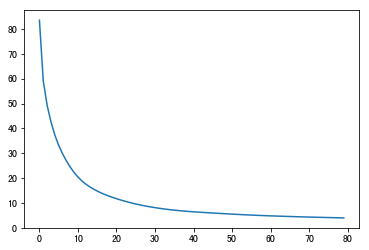

In [17]:
plt.plot(losses)